In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import stitch
import utils
import features

In [2]:
def convertResult(img):
    '''Because of your images which were loaded by opencv, 
    in order to display the correct output with matplotlib, 
    you need to reduce the range of your floating point image from [0,255] to [0,1] 
    and converting the image from BGR to RGB:'''
    img = np.array(img,dtype=float)/float(255)
    img = img[:,:,::-1]
    return img
def show_img2(img1):
#     imgRGBs1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)  # 图片格式转换：BGR(OpenCV) -> RGB(PyQt5)
    plt.subplot(221)
    plt.imshow(img1,cmap="gray")
def show_img(img1):
    imgRGBs1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)  # 图片格式转换：BGR(OpenCV) -> RGB(PyQt5)
    plt.subplot(221)
    plt.imshow(imgRGBs1)

In [10]:
def findAndDescribeFeatures(image, opt="ORB"):
    """find and describe features of @image,
        if opt='SURF', SURF algorithm is used.
        if opt='SIFT', SIFT algorithm is used.
        if opt='ORB', ORB algorithm is used.
        @Return keypoints and features of img"""
    # Getting gray image
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if opt == "SURF":
        md = cv2.xfeatures2d.SURF_create()
    if opt == "ORB":
        md = cv2.ORB_create(nfeatures=3000)
    if opt == "SIFT":
        md = cv2.xfeatures2d.SIFT_create()
    # Find interest points and Computing features.
    keypoints, features = md.detectAndCompute(grayImage, None)
    # Converting keypoints to numbers.
    # keypoints = np.float32(keypoints)
    features = np.float32(features)
    return keypoints, features
def drawKeypoints(img, kp):
    """
    cv2.drawKeypoints(image, keypoints, outImage, color=None, flags=None)
    第一个参数image：原始图像，可以使三通道或单通道图像；
    第二个参数keypoints：特征点向量，向量内每一个元素是一个KeyPoint对象，包含了特征点的各种属性信息；
    第三个参数outImage：特征点绘制的画布图像，可以是原图像；
    第四个参数color：绘制的特征点的颜色信息，默认绘制的是随机彩色；
    第五个参数flags：特征点的绘制模式，其实就是设置特征点的那些信息需要绘制，那些不需要绘制，有以下几种模式可选：
    特征点的绘制模式，其实就是设置特征点的那些信息需要绘制，那些不需要绘制，有以下几种模式可选：
    DRAW_MATCHES_FLAGS_DEFAULT：只绘制特征点的坐标点，显示在图像上就是一个个小圆点，每个小圆点的圆心坐标都是特征点的坐标。
    DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG：函数不创建输出的图像，而是直接在输出图像变量空间绘制，要求本身输出图像变量就是一个初始化好了的，size与type都是已经初始化好的变量。
    DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS ：单点的特征点不被绘制。
    DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS：绘制特征点的时候绘制的是一个个带有方向的圆，这种方法同时显示图像的坐标，size和方向，是最能显示特征的一种绘制方式。

    """
    img1 = img
    cv2.drawKeypoints(img, kp, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img1

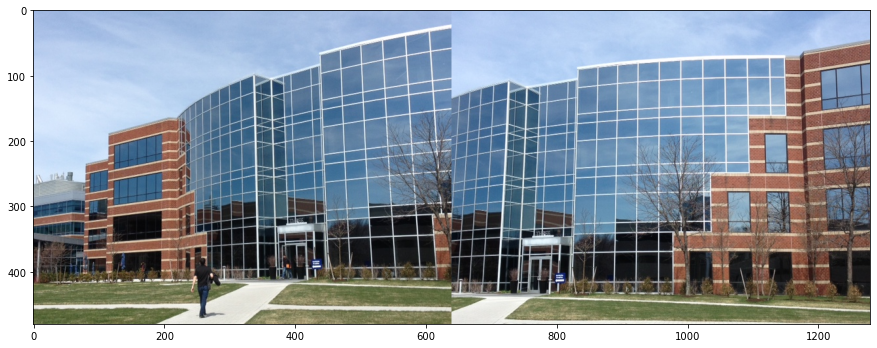

In [11]:
#load images
list_images=utils.loadImages('./data/building',resize=0)
plt_img = np.concatenate((list_images[0], list_images[1]), axis=1)
plt.figure(figsize=(15,15))
plt.imshow(convertResult(plt_img))

In [55]:
import copy # 深拷贝
gray_img1 = copy.copy(list_images[0])
gray_img2 = copy.copy(list_images[1])

grayImage1 = cv2.cvtColor(gray_img1, cv2.COLOR_BGR2GRAY)
grayImage2 = cv2.cvtColor(gray_img2, cv2.COLOR_BGR2GRAY)

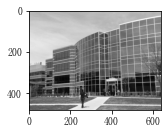

In [59]:
show_img2(grayImage1)

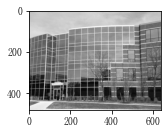

In [60]:
show_img2(grayImage2)

In [25]:
#extract keypoints and descriptors using sift
k0,f0=findAndDescribeFeatures(list_images[0],opt='SIFT')
k1,f1=findAndDescribeFeatures(list_images[1],opt='SIFT')

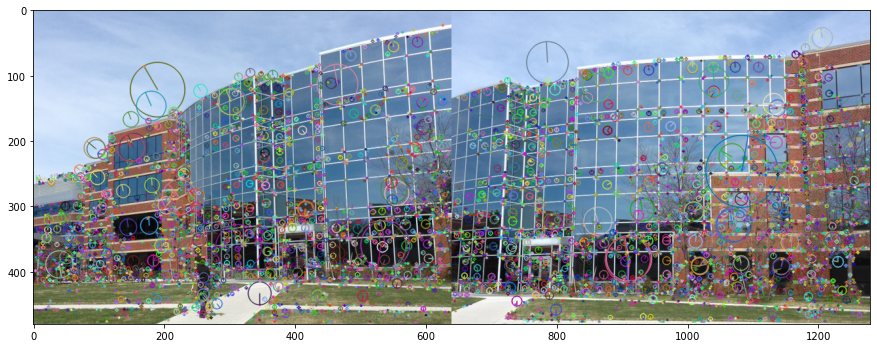

In [26]:
#draw keypoints
img0_kp=drawKeypoints(list_images[0],k0)
img1_kp=drawKeypoints(list_images[1],k1)

plt_img = np.concatenate((img0_kp, img1_kp), axis=1)
plt.figure(figsize=(15,15))
plt.imshow(convertResult(plt_img))

In [15]:
def matchFeatures(featuresA, featuresB, ratio=0.75, opt="FB"):
    """matching features beetween 2 @features.
         If opt='FB', FlannBased algorithm is used.
         If opt='BF', BruteForce algorithm is used.
         @ratio is the Lowe's ratio test.
         @return matches"""
    if opt == "BF":
        featureMatcher = cv2.DescriptorMatcher_create("BruteForce")
    if opt == "FB":
        # featureMatcher = cv2.DescriptorMatcher_create("FlannBased")
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        featureMatcher = cv2.FlannBasedMatcher(index_params, search_params)

    # performs k-NN matching between the two feature vector sets using k=2
    # (indicating the top two matches for each feature vector are returned).
    matches = featureMatcher.knnMatch(featuresA, featuresB, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    if len(good) > 4:
        return good
    raise Exception("Not enought matches")

#matching features using BruteForce 

In [27]:
#matching features using BruteForce 
mat=features.matchFeatures(f0,f1,ratio=0.6,opt='BF')

In [28]:
def generateHomography(src_img, dst_img, ransacRep=5.0):
    """@Return Homography matrix, @param src_img is the image which is warped by homography,
        @param dst_img is the image which is choosing as pivot, @param ratio is the David Lowe’s ratio,
        @param ransacRep is the maximum pixel “wiggle room” allowed by the RANSAC algorithm
        """

    src_kp, src_features = findAndDescribeFeatures(src_img)
    dst_kp, dst_features = findAndDescribeFeatures(dst_img)

    good = matchFeatures(src_features, dst_features)

    src_points = np.float32([src_kp[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_points = np.float32([dst_kp[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, ransacRep)
    matchesMask = mask.ravel().tolist()
    return H, matchesMask

In [29]:
#Computing Homography matrix and mask
H,matMask=features.generateHomography(list_images[0],list_images[1])

In [30]:
def drawMatches(src_img, src_kp, dst_img, dst_kp, matches, matchesMask):
    draw_params = dict(
        matchColor=(0, 255, 0),  # draw matches in green color
        singlePointColor=None,
        matchesMask=matchesMask[:100],  # draw only inliers
        flags=2,
    )
    return cv2.drawMatches(
        src_img, src_kp, dst_img, dst_kp, matches[:100], None, **draw_params
    )

In [34]:
# #draw matches
# img= drawMatches(list_images[0],k0,list_images[1],k1,mat,matMask)
# plt.figure(figsize=(15,15))
# plt.imshow(convertResult(img))
print("bug")

bug


In [35]:
#wrap 2 image
#choose list_images[0] as desination
pano,non_blend,left_side,right_side=stitch.warpTwoImages(list_images[1],list_images[0],True)

Exception: Please try again with another image set!

In [26]:
md1 = cv2.ORB_create(nfeatures=3000)
md2 = cv2.ORB_create(nfeatures=3000)
md3 = cv2.ORB_create(nfeatures=3000)
md4 = cv2.ORB_create(nfeatures=3000)
md5 = cv2.ORB_create(nfeatures=3000)

In [28]:
# 找到兴趣点和计算特性。
keypoints1, features1 = md1.detectAndCompute(gray_img1, None)
keypoints2, features2 = md2.detectAndCompute(gray_img2, None)
keypoints3, features3 = md3.detectAndCompute(gray_img3, None)
keypoints4, features4 = md4.detectAndCompute(gray_img4, None)
keypoints5, features5 = md5.detectAndCompute(gray_img5, None)

In [29]:
features1 = np.float32(features1)
features2 = np.float32(features2)
features3 = np.float32(features3)
features4 = np.float32(features4)
features5 = np.float32(features5)

In [41]:
ratio=0.75
opt="FB"
ransacRep=5.0

In [33]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
featureMatcher = cv2.FlannBasedMatcher(index_params, search_params)

In [34]:
matches23 = featureMatcher.knnMatch(features2, features3, k=2)

In [37]:
good23 = []
for m, n in matches23:
    if m.distance < ratio * n.distance:
        good23.append(m)

In [38]:
print(len(good23))

496


In [39]:
src_points = np.float32([keypoints2[m.queryIdx].pt for m in good23]).reshape(-1, 1, 2)
dst_points = np.float32([keypoints3[m.trainIdx].pt for m in good23]).reshape(-1, 1, 2)

In [42]:
H, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, ransacRep)
matchesMask = mask.ravel().tolist()